# Pruebas nuevo ForecasterAutoregMultiseries (0.12.0)

Funcionalidades a probar:

+ Series es dataframe y exog es dataframe

+ Series es dataframe y exog es diccionario con distintas exógenas para cada serie

+ Series es diccionario y exog es diccionario

+ Series es diccionario con series de diferente longitud:
    + Se almacena correctamente last_window
    + ¿Que series se permiten predecir?
    + ¿Que series se permiten predecir si se le pasa un last_window?

+ Series es diccionario y exog es diccionario con algunas exógenas con valores ausentes

+ Comparar impacto de diferentes encodings en terminos de predicción y tiempos de ejecución

In [128]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import datetime

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# Load preprocessed data
# ==============================================================================
data = pd.read_parquet('sample_building_consumption.parquet')
data = data.asfreq('D')
series = data[['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']].copy()
exog = data[['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']].copy()

end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'
series_train = series.loc[: end_train, :].copy()
series_val   = series.loc[end_train:end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()
exog_train = exog.loc[: end_train, :].copy()
exog_val   = exog.loc[end_train:end_validation, :].copy()
exog_test  = exog.loc[end_validation:, :].copy()

display(series_train)
display(exog_train)

,id_1000,id_1001,id_1002,id_1003,id_1004
timestamp,,,,,
2016-01-01,1012.500694,142.999700,3114.500198,2294.750893,7188.003021
2016-01-02,1158.500099,141.000801,4110.000000,1750.000198,8494.001007
2016-01-03,983.000099,137.000300,2965.000000,1455.750492,7130.001007
2016-01-04,1675.750496,133.000100,1269.500000,2141.000198,9955.000000
2016-01-05,1586.250694,127.000300,3360.500000,2384.870697,10519.001007
...,...,...,...,...,...
2016-07-27,1344.750595,2224.000198,5794.000000,1830.871780,8622.002014
2016-07-28,1310.000397,2334.000496,6306.000000,1776.250992,9045.001984
2016-07-29,1297.000893,2559.000595,5928.000000,1644.001091,8733.002014


,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
timestamp,,,,
2016-01-01,-0.433884,-0.900969,6.416639,4.040115
2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2016-01-03,-0.781831,0.623490,6.555272,3.273064
2016-01-04,0.000000,1.000000,6.704778,4.865404
2016-01-05,0.781831,0.623490,2.392998,5.228913
...,...,...,...,...
2016-07-27,0.974928,-0.222521,29.412603,3.851565
2016-07-28,0.433884,-0.900969,28.429901,3.274959
2016-07-29,-0.433884,-0.900969,26.399671,4.331137


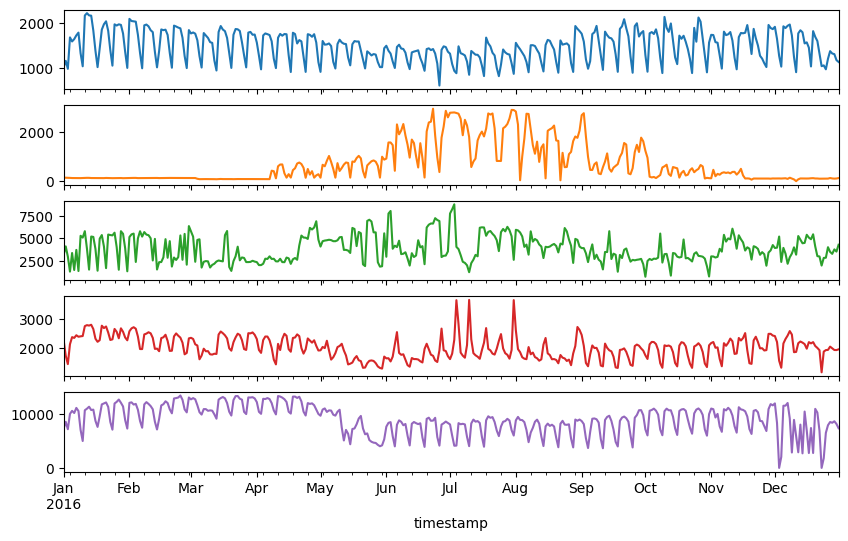

In [130]:
series.plot(subplots=True, figsize=(10, 6) , legend=False);

# Series is dataframe and exog is dataframe

In [131]:
# Series is dataframe and exog is dataframe
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train, exog=exog_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_1 = forecaster.predict(steps=5, exog=exog_val)
predictions_1

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-18 11:56:09

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


# Series is dataframe and exog is dictionary

In [132]:
# Series is dataframe and exog is dictionary
# ==============================================================================
exog_train_dict = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_2 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_2

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-18 11:56:09 
Last fit date: 2024-0

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


# Series is dictionary and exog is dictionary

In [133]:
# Series is dictionary and exog is dictionary
# ==============================================================================
series_train_dict = series_train.to_dict('series')
series_val_dict   = series_val.to_dict('series')
series_test_dict  = series_test.to_dict('series')
exog_train_dict = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train_dict, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_3 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_3

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-18 11:56:10 
Last fit date: 2024-0

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


In [134]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)
pd.testing.assert_frame_equal(predictions_1, predictions_3)

# Series is dataframe with series of different lengths (filled with NaNs) and exog is None

+ id_1000: serie completa de inicio a fin
+ id_1001: serie de inicio hasta la mitad
+ id_1002: serie de mitad hasta el final
+ id_1003: serie solo con dos intervalos 
+ id_1004: serie con un único intervalo en el medio

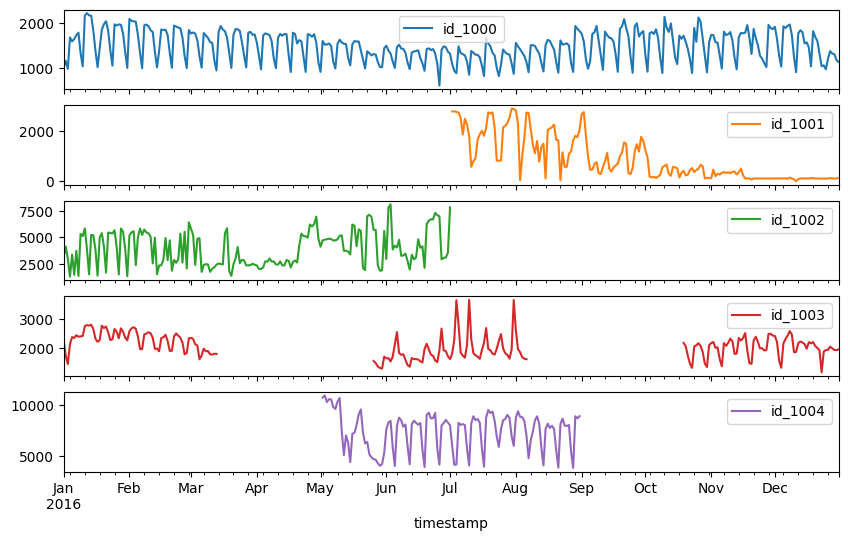

In [135]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_train = series.loc[: end_train, :].copy()
series_val   = series.loc[end_train:end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()

series.plot(subplots=True, figsize=(10, 6) , legend=True);

In [136]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series, drop_nan=False)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
display(forecaster.last_window)
print("")

/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:755: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  X_train = X_train.iloc[mask,]
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:776: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `drop_nan = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  if X_train.isnull().any().any():


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-12-31'], 'id_1001': ['2016-01-01', '2016-12-31'], 'id_1002': ['2016-01-01', '2016-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-18 11:56:12 
Last fit date: 2024-03-18 11:56:12 
Skforecast version: 0.12.0 
Python version: 3.12.0 
Forecaste

{'id_1000': timestamp
 2016-12-18    1034.750000
 2016-12-19    1813.999901
 2016-12-20    1687.000000
 2016-12-21    1596.000099
 2016-12-22    1316.499699
 2016-12-23    1040.750000
 2016-12-24    1058.250000
 2016-12-25     971.750000
 2016-12-26    1203.750000
 2016-12-27    1372.250000
 2016-12-28    1320.500000
 2016-12-29    1306.250000
 2016-12-30    1174.250000
 2016-12-31    1134.000000
 Freq: D, Name: id_1000, dtype: float64,
 'id_1001': timestamp
 2016-12-18    118.0000
 2016-12-19    122.0000
 2016-12-20    109.0000
 2016-12-21    108.0000
 2016-12-22    100.1304
 2016-12-23    101.6800
 2016-12-24    104.0000
 2016-12-25    103.9994
 2016-12-26    104.0002
 2016-12-27    127.0000
 2016-12-28    110.0000
 2016-12-29    103.0000
 2016-12-30    108.0000
 2016-12-31    125.0000
 Freq: D, Name: id_1001, dtype: float64,
 'id_1002': timestamp
 2016-06-18    4131.000000
 2016-06-19    2102.000000
 2016-06-20    6229.001007
 2016-06-21    6547.001007
 2016-06-22    6683.000000
 20

In [137]:
print('Predictions')
print('------------')
predictions_5 = forecaster.predict(steps=5, levels=['id_1000'])
predictions_5

Predictions
------------


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [138]:
print('Predictions')
print('------------')
predictions_6 = forecaster.predict(steps=5, levels=['id_1004'])
predictions_6

Predictions
------------


,id_1004
2016-09-01,8872.845743
2016-09-02,8211.528184
2016-09-03,5673.015082
2016-09-04,4063.923527
2016-09-05,8608.514987


In [139]:
print('Predictions')
print('------------')
predictions_7 = forecaster.predict(steps=5, levels=['id_1000', 'id_1004'])
predictions_7

Predictions
------------


/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:1283: IgnoredArgumentWarning: Only series whose last window ends at the same index can be predicted together. Series that not reach the maximum index, 2016-12-31 00:00:00, are excluded from prediction: {'id_1004'}. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  levels = selected_levels


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [140]:
print('Predictions')
print('------------')
predictions_8 = forecaster.predict(steps=5, levels=None)
predictions_8

Predictions
------------


,id_1000,id_1001,id_1003
2017-01-01,1052.310058,119.732235,2046.682242
2017-01-02,1348.389279,114.110698,2038.022302
2017-01-03,1455.782936,113.864170,2047.049785
2017-01-04,1415.239620,105.604602,1965.499059
2017-01-05,1398.959955,112.320310,1834.262846


# Series is dictionaty with series of different lengths (filled with NaNs) and exog is None

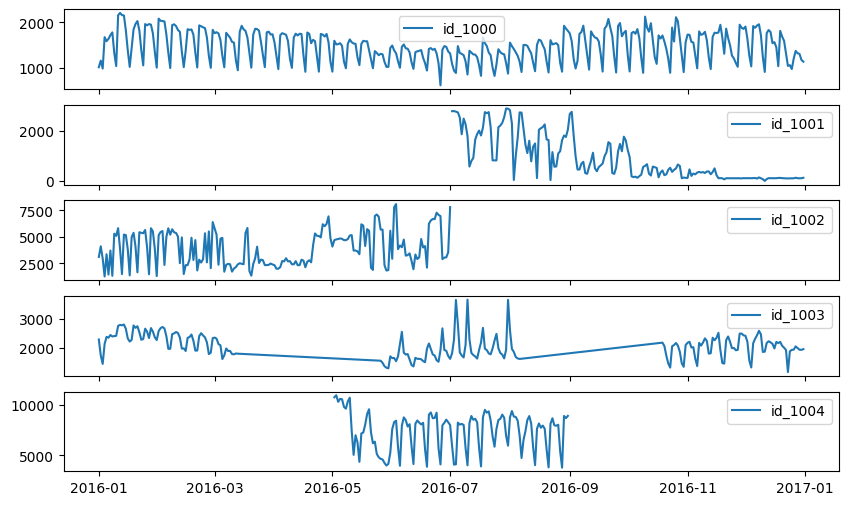

In [164]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}

fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)

for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name)
    axs[i].legend()

In [ ]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series_dict, drop_nan=False)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
display(forecaster.last_window)
print("")

# Puntos a revisar

+ ¿Exog en el predict tiene que ser necesariamente un dataframe? Ahora mismo hay conflicto de tipos. Predict espera un exog del mismo tipo que en train, pero tiene un check que en predict solo permite dataframe o serie. Si el forecaster se entrena con dict falla.